<a href="https://colab.research.google.com/github/Matammanjunath/template_codes_manju/blob/main/20220429_ArrayIVfrmStringIVs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this code, import string I-Vs computed at close timestamps and obtain array I-V
# This is good when sky is stable or consider clear sky data only

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.patches import Polygon
import natsort as ns
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import matplotlib.dates as matdates
import pandas as pd
import numpy as np
import itertools
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from google.colab import files
!cp /content/drive/MyDrive/00Python_Template_Files/plot_templates_manju.py .
import plot_templates_manju 
!cp /content/drive/MyDrive/00Python_Template_Files/ivcurves_data_extraction_functions.py .
import ivcurves_data_extraction_functions
!cp /content/drive/MyDrive/00Python_Template_Files/physics_utils.py .
import physics_utils
!cp /content/drive/MyDrive/00Python_Template_Files/preprocess.py .
import preprocess
#files.upload()
#files.download('plot_templates_manju.ipynb')
#import plot_templates_manju

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plot_templates_manju.oscilloscope_plot
# Functions
def high_res_dataframe(df, data_fre='1s'):
    """"df has timestamp index in '%Y-%m-%d %H:%M:%S' format, float cloumns. 
    The function initially creates an ideal, appends this to main df and this creates nans. Finally, NaNs are filled by interpolation"""
    high_residx = pd.date_range(df.index.strftime(
        '%Y-%m-%d %H:%M:%S')[0], df.index.strftime('%Y-%m-%d %H:%M:%S')[-1], freq='1s')
    df = df.reindex(high_residx)
    df.interpolate(method='index', inplace=True)
    return df

    def stable_sky_filter(df,poa_col_name='POA',stable_poa_seconds=60,stable_poa_wm2=15):
        """    
        Parameters
        ----------
        df : dataframe
            DESCRIPTION. Dataframe with index timestamp, dtype='datetime64[ns]'
        poa_col_name : string, optional
            DESCRIPTION. The default is 'POA'. It denotes name of the 
            plane of array irradiance or irradiance column.
        stable_poa_seconds : int, optional
            DESCRIPTION. The default is 1. Checking last 60s duration.
        stable_poa_wm2 : int, optional
            DESCRIPTION. The default is 15. Choose and check if change in the irradiance < 15 W/m2. 
            Value 15 W/m2/1 min was choosen after observing clear sky day profiles which changed not
            more than 15 W/m2 every minute.
    
        Returns
        -------
        df : TYPE
            DESCRIPTION. Returning the original dataframe after dropping unstable sky rows
        """
        df['index']=df.index
        df.reset_index(inplace=True,drop=True)
        samp_dur = np.nanmax(df['index'].diff(periods=1).dt.total_seconds().unique())
        samp = int(stable_poa_seconds/samp_dur)
        df['POA_dif'] = df['POA'].diff(periods=samp)
        df['unskystable?'] = df['POA_dif'].abs().ge(stable_poa_wm2)
        ## Check if unstable_sky is true or change in POA in last 1 min > 15 W/m2 and drop all rows in between
        if len(df[df['unskystable?']])>1:
            stable_idx = pd.concat(df.loc[i-samp:i:1] for i,r in df.iterrows() if r['unskystable?']==True).drop_duplicates(keep='first').index 
            df = df[~df.index.isin(stable_idx)].set_index('index')
        # drop the columns created in this function
        drop_cols = ['POA_dif','unskystable?']
        df.drop(drop_cols, axis=1, inplace=True)
        return df


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Data left after the POA filter is 42%


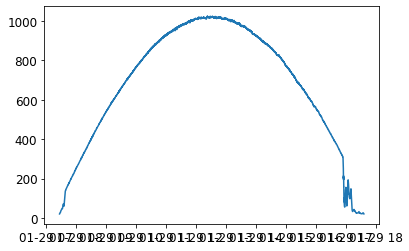

Index(['8157_S1groupchannel_name', '8157_S1current', '8157_S1voltage',
       '8157_S1irradiance', '8157_S1timestamp', '8157_S1t_dif',
       '8157_S1POA (W/m2)', '8157_S1power', '8157_S2groupchannel_name',
       '8157_S2current', '8157_S2voltage', '8157_S2irradiance',
       '8157_S2timestamp', '8157_S2t_dif', '8157_S2POA (W/m2)',
       '8157_S2power'],
      dtype='object')


/content/preprocess.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  procIs = np.array(procIs)
/content/preprocess.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  procVs = np.array(procVs)


In [ ]:
daylbl = '20190129'
# Import strings I-V data and produce array I-V curve
#### Import files 
fold_loc = '/content/drive/MyDrive/20220429_ArrayIVfrmStringIVs'
# Relevant file name
file_name = '/8157_Pordis_IVdata_%s'%(daylbl)
ivdf = pd.read_csv(fold_loc+'%s.csv'%(file_name))
# test times
ivdf['datetime'] = pd.to_datetime(ivdf['datetime'],format='%Y-%m-%d %H:%M:%S')
# Set datetime as index
ivdf.set_index('datetime',inplace=True,drop=True)
ivdf['timestamp'] = ivdf.index
# compute time difference between the scans or rows
ivdf['t_dif'] = ivdf['timestamp'].diff(periods=1).dt.total_seconds()
# print(ivdf.index)

## poa irradiance data
file_name = '/8157_Pordis_licorPOA_%s'%(daylbl)
poa = pd.read_csv(fold_loc+'%s.csv'%(file_name))
## Demelt the dataframe
poa = poa.pivot(index='measdatetime', columns='modbus_readout_id')['final_value']
col_ids = poa.columns.tolist()

## Import modbus readout ids and labels
mid = pd.read_csv(fold_loc+'/8157_MySql_ModbusReadoutIDs_Manju.csv')
req_labls = mid[mid['modbus_readout_id'].isin(col_ids)]
## Replace dataframe modbus ids with labels
poa.rename(columns=dict(zip(req_labls['modbus_readout_id'],req_labls['channel_name'])),inplace=True)
## drop unwanted columns
# df.drop(df.columns[0],inplace=True,axis=1)
# Set index
poa.index = pd.to_datetime(poa.index,format='%Y-%m-%d %H:%M:%S')
# Rename columns
poa.rename(inplace=True, columns={"Irradiance":"POA (W/m2)",
                                    "R02.C06_Temp":"TM1",
                                    "R02.C01_Temp":"TM6",
                                    "R01.C04_Temp":"TM10",
                                    "R02.C10_Temp":"TM15",
                                    "R01.C13_Temp":"TM20",
                                    "R01.C08_Temp":"TM23",
                                    "S_1_VOLTAGE":"S1Vdc (V)",
                                    "S_1_CURRENT":"S1Idc (A)",
                                    "S_2_VOLTAGE":"S2Vdc (V)",
                                    "S_2_CURRENT":"S2Idc (A)"})
## Filter-1: Drop low POA data
tn = len(poa)
poa = poa[poa['POA (W/m2)']>20]
print("Data left after the POA filter is %d%%"%(len(poa)*100/tn))
plt.plot(poa.index,poa['POA (W/m2)'])
plt.show()
### Append poa data to the ivdf
ivdf = pd.merge_asof(ivdf,poa['POA (W/m2)'],left_index=True,right_index=True,direction='nearest',tolerance=pd.Timedelta('6s'))
# print(ndf['POA (W/m2)'])

# change each cell data to list type
for i in ivdf.index:#range(len(ivdf)):
    vstr, istr = ivcurves_data_extraction_functions.string_to_float(
        ivdf.loc[i, 'voltage']), ivcurves_data_extraction_functions.string_to_float(ivdf.loc[i, 'current'])
    ivdf.at[i, 'voltage'], ivdf.at[i, 'current'] = vstr, istr

# Bring all I-V curves to a common voltage and resolution
ivdf = preprocess.preprocess(ivdf, volt_start=0, volt_resolution=1)

# Check each scan and identify the pairs 
# Time difference between S1 and S2 scans is around 270 sec. 
######## Scanning wise grouping of data
sm_list = []
for name in ivdf.groupchannel_name.unique():      
  sm_list.append(ivdf.loc[ivdf.groupchannel_name == name, :]) # print(len(sm_list))
# print(sm_list)
l = []
s1 = []
for i in range(0,len(sm_list),1):
#        print("%s scanned %d times"%(sm_list[i]['group'][0],len(sm_list[i])))
    if i==0:
        nm = sm_list[i]['groupchannel_name'][0]
        s1=sm_list[i].add_prefix(nm)  ####s1.dtypes, s1.index
        l.append(s1)
    else:             #sm_list[0]
        nm = sm_list[i]['groupchannel_name'][i]
#            sm_list[i].drop(['group','datetime'],inplace=True,axis=1)
        l.append(pd.merge_asof(s1,sm_list[i].add_prefix(nm),left_index=True,right_index=True,
                              direction='nearest',tolerance=pd.Timedelta('5min')))
combdf = pd.concat(l,axis=1) ### 
combdf = combdf.groupby(combdf.columns,axis=1,sort=False).first() #              
print(combdf.columns)
# import natsort as ns
# s = sorted(ns.natsorted([x for x in combdf.columns if x[0] == 'S']))
# m = sorted(ns.natsorted([x for x in combdf.columns if x[0] == 'M']))
# combdf = combdf[s + m]
#     #### total group scans
tgs = len(combdf)
combdf['delT'] = (combdf['8157_S2timestamp'] - combdf['8157_S1timestamp']).dt.total_seconds()

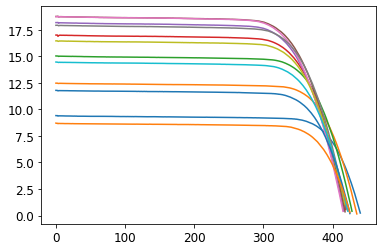

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


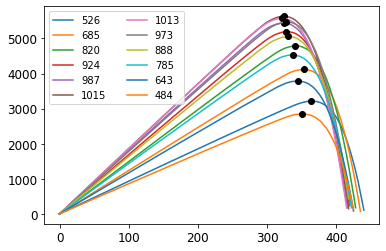

In [ ]:
## Filter low irradiance scans
combdf = combdf.loc[combdf['8157_S1POA (W/m2)']>200]
# pd.DataFrame(columns=['voltage','current','power','datetime'],index=n_cond)
combdf['Array current (A)'] = combdf[['8157_S1current','8157_S2current']].apply(lambda x:[sum(x) for x in zip(x[0],x[1])],axis=1)
combdf['Array voltage (V)'] = combdf['8157_S1voltage']
combdf['Array power (W)'] = combdf[['8157_S1current','8157_S2current','Array voltage (V)']].apply(lambda x: [(i+j)*z for i,j,z in zip(x[0],x[1],x[2])],axis=1) # zip(*x)
# Drop the array data points in current or voltage to ensure both of same lenghts
# Minimum number of data points either in array voltage or current samples
combdf['Min.I-V samples'] = combdf[['Array current (A)','Array voltage (V)']].apply(lambda x:min(len(x[0]),len(x[1])),axis=1)
combdf['Array current (A)'] = combdf[['Array current (A)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
combdf['Array voltage (V)'] = combdf[['Array voltage (V)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
combdf['Array power (W)'] = combdf[['Array power (W)','Min.I-V samples']].apply(lambda x:x[0][:x[1]],axis=1) 
# Find MPP voltage of the each curve
combdf['Array mpp idx'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: np.argmax(x[0]),axis=1)
combdf['Array Vmpp (V)'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: x[1][np.argmax(x[0])],axis=1)
# print(combdf[['Array mpp idx','Array Vmpp (V)']])
combdf['Array Pmpp (W)'] = combdf[['Array power (W)','Array voltage (V)']].apply(lambda x: np.max(x[0]),axis=1)
# # # plot i-v curves
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array current (A)'].loc[i])
plt.show()
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i],
             label='%d'%(combdf['8157_S1POA (W/m2)'].loc[i]))
    plt.plot(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'ko')
plt.legend(loc='best',fontsize=10,ncol=2)
plt.show()

# sns.set(font_scale=1.2)
# sns_plot = sns.relplot(x='Array voltage (V)',
#                 y='Array current (A)',
#                 # y='Array Power (W)',
#                 # y='dP/dV (W/V)',
#               data=combdf, hue='datetime',
#               kind='line')
# # plt.axis([0,430,0,ardf['Array Current (A)'].max()*1.1])
# # plt.axis([270,430,0,ardf['Array Power (W)'].max()*1.1])
# # plt.axis([200,430,ardf['dP/dV (W/V)'].min()*1.1,ardf['dP/dV (W/V)'].max()*1.1])
# temp_name3 = 'ArrayCurves.png'
# # plt.subplots_adjust(left=0.05, right=0.99, top=0.99, bottom=0.05)        
# sns_plot.savefig(temp_name3,bbox_inches='tight',pad_inches=0.1, dpi=250)
# # plt.close()
# plt.show()


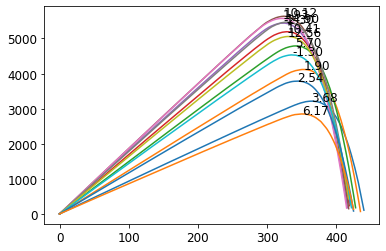

In [ ]:
## Filter the I-V curves and drop the untrackable MPPs
## Use gradient approach (d/dx) for computing  
## Ref: https://stackoverflow.com/questions/9876290/how-do-i-compute-derivative-using-numpy
np.gradient([10,20,30,40,10],[1,2,3,4,5])
combdf['Grad'] = combdf[['Array voltage (V)','Array power (W)','Array mpp idx']].apply( lambda row: sum(np.gradient(row[1][row[2]-5:row[2]+5:],row[0][row[2]-5:row[2]+5:])),axis=1)
## plot MPP gradients and sum
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i])
    plt.text(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'%.2f'%(combdf['Grad'].loc[i]))
plt.show()
# print(combdf['Grad'].sort_values())

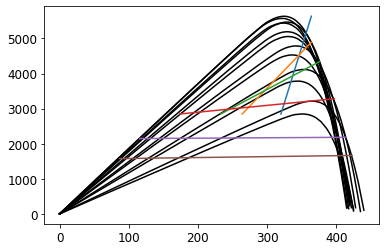

In [ ]:
Nsm = 12#12
Nps = 2#44
Pmod_stc = 270 
pstc = Nsm*Nps*Pmod_stc 


dcac = [1,1.33,1.5]+list(np.linspace(2,4,3))
pdcac = [pstc/i for i in dcac]
clpdf = pd.DataFrame({'DC/AC Ratio':dcac})
clpdf['Clipping Power (kW)'] = pstc/clpdf['DC/AC Ratio']
## Clip levels 
plvl,vlvl = [],[]
for i in range(len(clpdf)):
    plimit = clpdf.loc[i,'Clipping Power (kW)']
    ### Find values closely matching a given value with a tolerance
    tol = 0.1
    def f(x):
        a = np.abs(np.array(x)-plimit)
        m = a <= tol * plimit
        return np.nanargmin(np.where(m, a, np.nan)) if m.any() else np.nan
    # p.append([plimit]*2)
    # xdf = combdf.loc[combdf['Array Pmpp (W)']>plimit,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)','Array Pmpp (W)']]
    xdf = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)','Array Pmpp (W)']]
    # plvl.append()
    # print(xdf.columns)
    if len(xdf) > 1: 
      ## Slice the array voltage points of I-V curve falling on left side of the MPP only
      xdf['Array voltage (V)'] = xdf[['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']].apply(lambda x:x[0][:x[1]],axis=1) #x[3][:x[1]]]
      ## Slice the array power points of P-V curve falling on left side of the MPP only
      xdf['Array power (W)'] = xdf[['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']].apply(lambda x:x[3][:x[1]],axis=1)
      ## Substract clipping power limit from each data point on the left side of MPP and take absolure values and find the index of minimum value
      xdf['Pminidx'] = (xdf['Array power (W)'].map(np.array)-plimit).map(abs).map(np.argmin)
      # xdf['Pminidx'] = xdf['Array power (W)'].map(f)
      # df1 = pd.DataFrame(xdf['Array power (W)'].tolist(), index=xdf['Array power (W)'].index).sub(plimit).abs()
      # xdf['Pminidx'] = df1.where(df1 <= plimit * tol).dropna(how='all').idxmin(axis=1)
      pclip1 = xdf[['Array power (W)','Pminidx']].apply(lambda x:x[0][x[1]],axis=1).values
      ## Find the voltage corresponding to each 
      vlow = xdf[['Array voltage (V)','Pminidx']].apply(lambda x:x[0][x[1]],axis=1).values
      ## Ref: https://stackoverflow.com/questions/72078621/python-dataframe-process-two-columns-of-lists-and-find-minimum/72078660#72078723
      ### One line solution
      # v1 = xdf[['Array voltage (V)','Array power (W)']].apply(lambda row: row['Array voltage (V)'][np.argmin(abs(np.array(row['Array power (W)'])-plimit))],axis=1)
      ## Again extract xdf dataframe
      # xdf = combdf.loc[combdf['Array Pmpp (W)']>plimit,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)','Array Pmpp (W)']]
      xdf = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)','Array Pmpp (W)']]
      ## Slice the array voltage points of I-V curve falling on right side of the MPP only
      xdf['Array voltage (V)'] = xdf[['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']].apply(lambda x:x[0][x[1]:],axis=1) #x[3][:x[1]]]
      ## Slice the array power points of P-V curve falling on right side of the MPP only
      xdf['Array power (W)'] = xdf[['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']].apply(lambda x:x[3][x[1]:],axis=1)
      ## Substract clipping power limit from each data point on the left side of MPP and take absolure values and find the index of minimum value
      xdf['Pminidx'] = (xdf['Array power (W)'].map(np.array)-plimit).map(abs).map(np.argmin)
      # xdf['Pminidx'] = xdf['Array power (W)'].map(f)
      ## Power 
      pclip2 = xdf[['Array power (W)','Pminidx']].apply(lambda x:x[0][x[1]],axis=1).values
      ## Find the voltage corresponding to each 
      vhigh = xdf[['Array voltage (V)','Pminidx']].apply(lambda x:x[0][x[1]],axis=1).values
      # print(min(vlow),max(vlow))
      # vlvl.append([[min(vlow),max(vlow)],[min(vhigh),max(vhigh)]])   
      # plvl.append([[min(pclip1),max(pclip1)],[min(pclip2),max(pclip2)]])
      ## Create a new dataframe
      vcl = np.concatenate((vlow,vhigh),axis=None)
      pcl = np.concatenate((pclip1,pclip2),axis=None) 
      xdf = pd.DataFrame({'vclp':vcl,'pclp':pcl})
      xdf = xdf.sort_values('vclp') 
      vlvl.append([xdf['vclp'].min(),xdf['vclp'].max()])   
      plvl.append([xdf['pclp'].min(),xdf['pclp'].max()]) 
clpdf['Clip power (W)'] = plvl
clpdf['Clip voltage (V)'] = vlvl
### Plot P-V curves and clip levels
for i in combdf.index:
    plt.plot(combdf['Array voltage (V)'].loc[i],combdf['Array power (W)'].loc[i],'k')
    # plt.text(combdf['Array Vmpp (V)'].loc[i],combdf['Array Pmpp (W)'].loc[i],'%.2f'%(combdf['Grad'].loc[i]))
for j in clpdf.index:
    plt.plot(clpdf['Clip voltage (V)'].loc[j],clpdf['Clip power (W)'].loc[j],label='%.2f'%(clpdf['DC/AC Ratio'].loc[j]))
    # plt.text(clpdf['Clip voltage (V)'].loc[j],clpdf['Clip power (W)'].loc[j],'%d'%(clpdf['Clip voltage (V)'].loc[j]))
# plt.legend(loc='best',fontsize=10,ncol=2)  
plt.show()

In [43]:
dcac = [1,1.33,1.5]+list(np.linspace(2,4,3))
pdcac = [pstc/i for i in dcac]
clpdf = pd.DataFrame({'DC/AC Ratio':dcac})
clpdf['Clipping Power (kW)'] = pstc/clpdf['DC/AC Ratio']
## Clip levels 
plvl,vlvl = [],[]
for i in range(len(clpdf)):
    ### ratio of dcac powers
    rda = clpdf.loc[i,'DC/AC Ratio']
    plimit = clpdf.loc[i,'Clipping Power (kW)']
    # xdf = pd.DataFrame({'A':combdf.loc[combdf['Array Pmpp (W)']>plimit,'Array power (W)']})
    # xdf = combdf.loc[combdf['Array Pmpp (W)']>plimit,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    val = plimit
    tol = 0.05
    # xdf['samples'] = xdf.apply(lambda x: len(x['Array power (W)']),axis=1)
    # print(xdf[['Array mpp idx','samples']])
    # xdf = xdf.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']],axis=1)
    ## High voltage side clipping points
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    ## Extract the I-V or P-V curve samples right side the MPP
    df1 = df1.apply(lambda x: x['Array power (W)'][x['Array mpp idx']::1],axis=1)
    ## convert the column of lists into a dataframe of elements, where, each element is a sample, column denotes list index number
    ## All lists or P-V curves of different size; NaN cans be seen in this below dataframe towards the end in some of the rows
    ## After converint to dataframe, substract plimit value from each element and obtain absolute values as some may be +ve or -ve.
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    ## Each element in above dataframe denotes error (sample - clip power limit). Compare this to tolerance value. 
    ## Among the values satisfisying the error, identify the index of the minimum error and call it a matching index
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    ## Create a new dataframe with P-V voltage, matching index 
    df2 = pd.DataFrame({'Array voltage (V)':combdf.apply(lambda x: x['Array voltage (V)'][x['Array mpp idx']::1],axis=1),
                        'matching_index': df1['matching_index']})
    # Extract the matching index voltage values and store them to the original dataframe. 
    # Include the dc/ac ratio values in column name and this is high voltage side only
    combdf['rda%s_vh'%(rda)] = df2.apply(lambda x: x['Array voltage (V)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1) #combdf.apply(lambda x: x['Array voltage (V)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1)
    ## Low voltage side clipping points
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    ## Extract the I-V or P-V curve samples right side the MPP
    df1 = df1.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']:1],axis=1)
    ## convert the column of lists into a dataframe of elements, where, each element is a sample, column denotes list index number
    ## All lists or P-V curves of different size; NaN cans be seen in this below dataframe towards the end in some of the rows
    ## After converint to dataframe, substract plimit value from each element and obtain absolute values as some may be +ve or -ve.
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    ## Each element in above dataframe denotes error (sample - clip power limit). Compare this to tolerance value. 
    ## Among the values satisfisying the error, identify the index of the minimum error and call it a matching index
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    ## Create a new dataframe with P-V voltage, matching index 
    df2 = pd.DataFrame({'Array voltage (V)':combdf['Array voltage (V)'],
                        'matching_index': df1['matching_index']})
    # Extract the matching index voltage values and store them to the original dataframe. 
    # Include the dc/ac ratio values in column name and this is high voltage side only
    df1 = combdf.loc[:,['Array voltage (V)','Array mpp idx','Array Vmpp (V)','Array power (W)']]
    df1 = df1.apply(lambda x: x['Array power (W)'][:x['Array mpp idx']],axis=1)
    df1 = pd.DataFrame(df1.tolist(), index=df1.index).sub(val).abs()
    df1['matching_index'] = df1.where(df1 <= val * tol).idxmin(axis=1)
    df2 = pd.DataFrame({'Array voltage (V)':combdf.apply(lambda x: x['Array voltage (V)'][:x['Array mpp idx']:1],axis=1),
                        'matching_index': df1['matching_index']})
    # print(df2.columns)
    combdf['rda%s_vl'%(rda)] = df2.apply(lambda x: x['Array voltage (V)'][int(x['matching_index'])] if pd.notna(x['matching_index']) else np.nan,axis=1)
    ## Extract minimum and maximum voltage levels and append it to the clipping df
    # plvl.append()
print(combdf[['rda3.0_vl','Array Vmpp (V)','rda3.0_vh']])


                     rda3.0_vl  Array Vmpp (V)  rda3.0_vh
datetime                                                 
2019-01-29 08:57:17      234.0           364.0      414.0
2019-01-29 09:37:17      175.0           353.0      414.0
2019-01-29 10:17:17      145.0           341.0      410.0
2019-01-29 10:57:17      128.0           328.0      402.0
2019-01-29 11:37:17      120.0           324.0      399.0
2019-01-29 12:17:17      116.0           324.0      401.0
2019-01-29 12:57:17      116.0           322.0      398.0
2019-01-29 13:37:17      121.0           327.0      404.0
2019-01-29 14:17:17      132.0           330.0      402.0
2019-01-29 14:57:17      151.0           337.0      403.0
2019-01-29 15:37:17      185.0           344.0      402.0
2019-01-29 16:17:17      253.0           350.0      394.0
